## File for creating extent for Temperature data analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [2]:
#Read in whales data
whale_df = pd.read_csv("data/whales.csv")
#Turn Date into datetime:
whale_df['timestamp'] = pd.to_datetime(whale_df.timestamp)

In [3]:
#only get some columns then we will name them to be easier to reference:
whale_small = whale_df[['timestamp', 'location-long',	'location-lat', 'individual-local-identifier']]
whale_small = whale_small.rename(columns={"timestamp": "time", "location-lat": "lat", "location-long": "long", "individual-local-identifier": "id"})

In [4]:
#get rid of two outliers that are located way inland(no way they can be in a river over there)
whale_small = whale_small[whale_small['long'] < 0]

In [5]:
#Lets just visualize here:

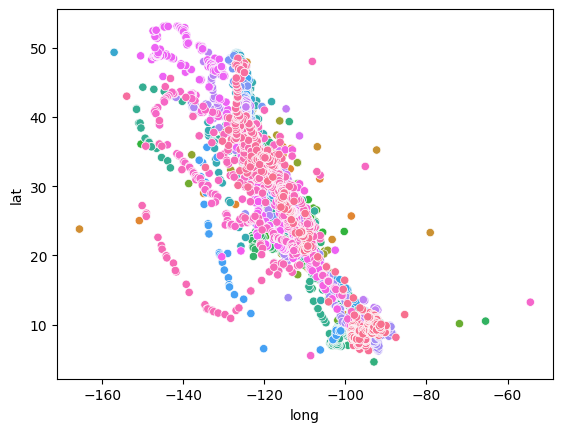

In [6]:
sns.scatterplot(data=whale_small, y="lat", x="long", hue="id", legend=False);
plt.savefig('exports/AllWhales.png', bbox_inches='tight')

In [7]:
#define range of lat/long for temperature data:
min_long = np.min(whale_small['long'])
min_lat = np.min(whale_small['lat'])
max_lat = np.max(whale_small['lat'])
max_long = np.max(whale_small['long'])

In [8]:
#Export the data
extent = pd.DataFrame({'Type': ['Lat', 'long'], 'min': [min_lat, min_long],
                   'max': [max_lat, max_long]})
extent.to_csv('./exports/extent.csv')  

In [9]:
whale_small.head()

,time,long,lat,id
0,1993-08-29 01:13:00,-122.433,37.058,1993CA-Bmu-00834
1,1993-08-28 18:20:00,-122.412,37.012,1993CA-Bmu-10823
2,1993-08-28 18:54:00,-122.415,37.022,1993CA-Bmu-10833
3,1993-08-31 23:40:00,-122.773,37.198,1993CA-Bmu-10836
4,1994-09-13 21:28:00,-123.102,37.687,1994CA-Bmu-10820


In [10]:
whale_small.time

0       1993-08-29 01:13:00
1       1993-08-28 18:20:00
2       1993-08-28 18:54:00
3       1993-08-31 23:40:00
4       1994-09-13 21:28:00
                ...        
16244   2008-06-03 19:13:04
16245   2008-06-04 22:27:15
16246   2008-06-11 11:42:10
16247   2008-06-11 11:59:00
16248   2008-06-13 19:08:34
Name: time, Length: 16247, dtype: datetime64[ns]

In [11]:
whales_1999 = whale_small[whale_small['time'].dt.year == 1999]
whales_2008 = whale_small[whale_small['time'].dt.year == 2008]

#Turn into geodataframe:
w1999 = gpd.GeoDataFrame(
    whales_1999, geometry=gpd.points_from_xy(whales_1999.long, whales_1999.lat), crs="EPSG:3310"
)

w2008 = gpd.GeoDataFrame(
    whales_2008, geometry=gpd.points_from_xy(whales_2008.long, whales_2008.lat), crs="EPSG:3310"
)

Text(0, 0.5, 'Latitude (Degrees)')

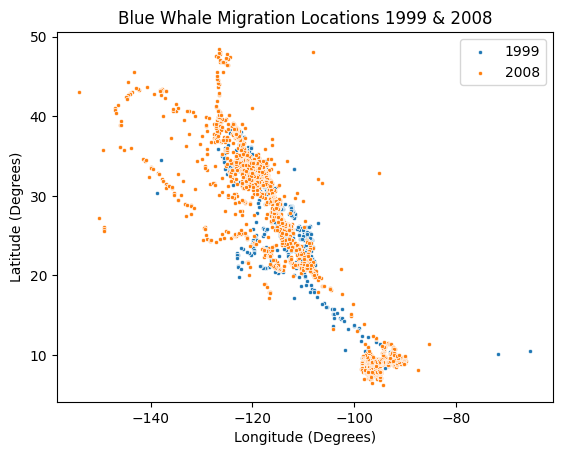

In [12]:
sns.scatterplot(data=w1999, y="lat", x="long", marker='.', label='1999');
sns.scatterplot(data=w2008, y="lat", x="long", marker='.', label='2008');

plt.title('Blue Whale Migration Locations 1999 & 2008')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')

Text(0, 0.5, 'Latitude (Degrees)')

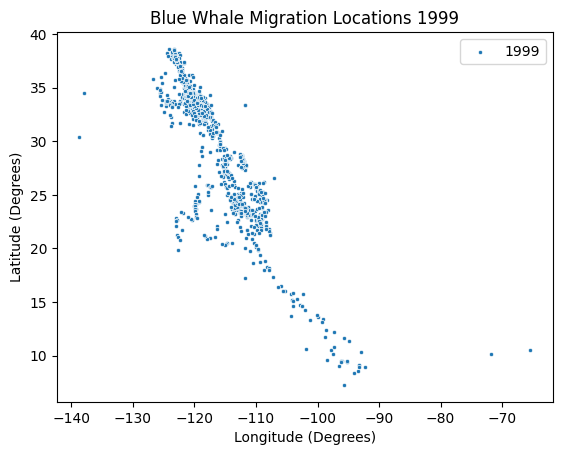

In [13]:
sns.scatterplot(data=w1999, y="lat", x="long", marker='.', label='1999');
plt.title('Blue Whale Migration Locations 1999')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')

Text(0, 0.5, 'Latitude (Degrees)')

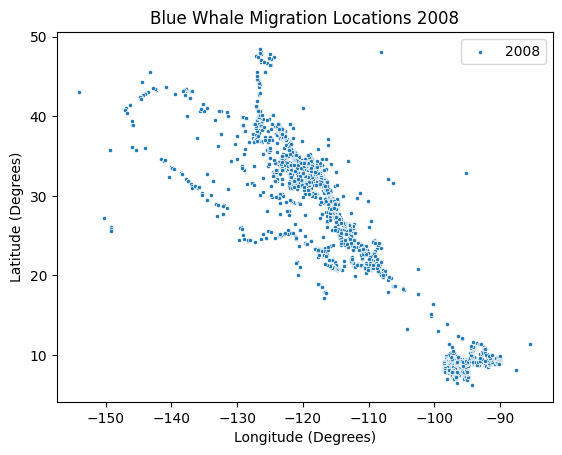

In [14]:
sns.scatterplot(data=w2008, y="lat", x="long", marker='.', label='2008');
plt.title('Blue Whale Migration Locations 2008')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')

In [15]:
#Average distance changes
w2008.nunique()

time        3302
long        2985
lat         2857
id            22
geometry    3304
dtype: int64

In [16]:
w1999.nunique()

time        1644
long        1448
lat         1359
id            21
geometry    1646
dtype: int64

In [17]:
#Make sure all whales are sorted for next step

w1999 = w1999.sort_values(['id', 'time'])
w2008 = w2008.sort_values(['id', 'time'])

w2008.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
def calc_dist_from_prev(geodata):
    '''if the id is the same previously, we calculate distance traveled from each point'''
    total_distances = []
    total_distance = 0
    distances_for_gpd = []
    for i in range(len(geodata)):
        row = geodata.iloc[i, :]

        #if first in the table (we cant look at the previous one)
        if i == 0:
            total_distance += 0
            #append 0 for gpd
            distances_for_gpd = np.append(distances_for_gpd, 0)

        #if not first in the table
        else:
            #get the previous row
            prev_row = geodata.iloc[i - 1, :]

            curr_point = Point(row['long'], row['lat'])
            prev_point = Point(prev_row['long'], prev_row['lat'])
            
            #if row id matched previous id:
            if row.id == prev_row.id:
            #calculate distance between points
                distance = curr_point.distance(prev_point)
                total_distance += distance
                #append for gpd
                distances_for_gpd = np.append(distances_for_gpd, distance)
                
            else:
                #append 0 for gpd
                distances_for_gpd = np.append(distances_for_gpd, 0)
                total_distances = np.append(total_distances, total_distance)
                total_distance = 0 
    #for the last point:
    total_distances = np.append(total_distances, total_distance)
    geodata['distances'] = distances_for_gpd
    return total_distances          

In [19]:
distances_1999 = calc_dist_from_prev(w1999)
distances_2008 = calc_dist_from_prev(w2008)
mean_dist_1999 = np.sum(distances_1999)
mean_dist_2008 = np.sum(distances_2008)
change = np.abs(mean_dist_1999-mean_dist_2008)
change

1017.2186220101853

In [20]:
w1999.sort_values(['id', 'time'])

,time,long,lat,id,geometry,distances
964,1999-02-21 15:09:18,-112.277,25.533,1998CA-Bmu-00824,POINT (-112.277 25.533),0.000000
965,1999-03-12 16:30:43,-113.582,25.897,1998CA-Bmu-00824,POINT (-113.582 25.897),1.354814
966,1999-03-14 23:16:39,-114.355,26.996,1998CA-Bmu-00824,POINT (-114.355 26.996),1.343626
967,1999-03-15 11:48:58,-114.797,27.259,1998CA-Bmu-00824,POINT (-114.797 27.259),0.514328
968,1999-03-15 23:57:31,-115.032,27.586,1998CA-Bmu-00824,POINT (-115.032 27.586),0.402683
...,...,...,...,...,...,...
3903,1999-12-14 16:00:28,-122.007,21.730,1999CA-Bmu-23043,POINT (-122.007 21.730),1.094697
3904,1999-12-15 12:00:55,-122.871,21.247,1999CA-Bmu-23043,POINT (-122.871 21.247),0.989841
3905,1999-12-15 17:16:22,-122.755,21.083,1999CA-Bmu-23043,POINT (-122.755 21.083),0.200878
3906,1999-12-16 04:21:51,-122.272,20.831,1999CA-Bmu-23043,POINT (-122.272 20.831),0.544787


In [21]:
mw2008 = w2008.to_crs('EPSG:5070')
mw2008.bounds

,minx,miny,maxx,maxy
11325,-2.065077e+06,1.926857e+06,-2.065077e+06,1.926857e+06
11326,-2.065077e+06,1.926857e+06,-2.065077e+06,1.926857e+06
11327,-2.065077e+06,1.926857e+06,-2.065077e+06,1.926857e+06
11328,-2.065077e+06,1.926856e+06,-2.065077e+06,1.926856e+06
11329,-2.065077e+06,1.926856e+06,-2.065077e+06,1.926856e+06
...,...,...,...,...
16244,-2.065077e+06,1.926856e+06,-2.065077e+06,1.926856e+06
16245,-2.065078e+06,1.926857e+06,-2.065078e+06,1.926857e+06
16246,-2.065080e+06,1.926861e+06,-2.065080e+06,1.926861e+06
16247,-2.065080e+06,1.926861e+06,-2.065080e+06,1.926861e+06


AttributeError: 'GeoDataFrame' object has no attribute 'expore'